Revert Extraction Analysis
===

Do some analysis on reverts.

In [1]:
import mwapi
import mwxml
import mwxml.utilities
import mwcli
import mwreverts
import oresapi
import mwparserfromhell

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import os
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [266]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [229]:
figures_dir = os.path.join(git_root_dir, "figures")
figures_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/figures'

In [5]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
working_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-reverts'

In [7]:
article_index_path = os.path.join(raw_data_dir, "enwiki-20200101-pages-articles-multistream-index.txt")
article_index = open(article_index_path).readlines()
len(article_index)

19881980

In [8]:
page_title_dict = {}
for line in tqdm(article_index):
    tokens = line.strip().split(":")
    #page_start_bytes = int(tokens[0])
    page_id = int(tokens[1])
    page_title = "".join(tokens[2:])
    page_title_dict[page_id] = page_title
len(page_title_dict)

100%|██████████| 19881980/19881980 [00:33<00:00, 584793.38it/s]


19881980

In [9]:
stub_history_dir = os.path.join(raw_data_dir, "enwiki-20200101-stub-meta-history-gz")
assert os.path.exists(stub_history_dir)

In [10]:
paths = [os.path.join(stub_history_dir, stub_history_filename) 
         for stub_history_filename in os.listdir(stub_history_dir)
         if stub_history_filename.endswith(".xml.gz")]
len(paths)

27

In [11]:
start_date = datetime.fromisoformat('2018-01-01')
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01')
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1514786400, 1577858400)

### Load in all revisions

Which excludes revisions outside of 2018-2020 and only for pages in ns0 and non-redirects.

In [12]:
start = datetime.now()
rev_ids_filepath = os.path.join(working_dir, 'rev_ids_sorted.csv')
df = pd.read_csv(rev_ids_filepath,
                 header=None, 
                 names=['page_id', 'rev_id', 'rev_timestamp', 'is_revert_target', 'is_reverted', 'is_reverting']
)
print(f"{datetime.now() - start}")
len(df)

0:00:32.284334


77287697

In [13]:
df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting
0,12,818611292,1515101356,0,0,0
1,12,818613649,1515102279,0,0,0
2,12,818624114,1515106953,1,0,0
3,12,820024812,1515798752,0,1,0
4,12,820025687,1515799060,0,0,1


In [14]:
# number of unique pages in this sample
page_ids_set = set(df.page_id)
len(page_ids_set)

5338582

In [257]:
page_id_list = list(page_ids_set)
page_title_list = [page_title_dict[page_id] for page_id in page_ids_set]
page_title_df = pd.DataFrame({'page_id': page_id_list, 'page_title': page_title_list})
page_title_df.head()

,page_id,page_title
0,16777218,Eduardo Pitta
1,12,Anarchism
2,50331663,Abdullah Mostafa
3,16777236,2011 Pacific Games
4,25,Autism


In [27]:
reverts = []
paths = [os.path.join(working_dir, fname) for fname in os.listdir(working_dir) if fname.endswith("-reverts.ndjson")]
print(f"Loading reverts from {len(paths)} ndjson files.")
for path in tqdm(paths):
    with open(path, 'r') as infile:
        for line in infile:
            if line.strip() == "":
                continue
            revert = eval(line.strip())
            reverts.append(revert)
len(reverts)

  0%|          | 0/27 [00:00<?, ?it/s]

Loading reverts from 27 ndjson files.


100%|██████████| 27/27 [27:36<00:00, 61.34s/it] 


5992682

In [29]:
bins = []
bins.append(int(start_date.timestamp()))
year = 2018
month = 1
while not (year == 2020 and month == 1):
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(int(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp()))
len(bins)

25

In [30]:
cmap = matplotlib.cm.Set2

In [31]:
page_revert_counts = np.array([
        len(list(page_reverts)) for page, page_reverts in groupby(reverts, lambda revert: revert['reverting']['page']['id'])
    ])
len(page_revert_counts)

1163799

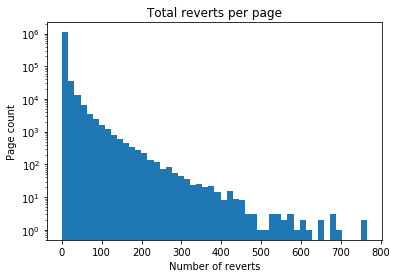

1163799

In [33]:
plt.hist(page_revert_counts, bins=50, log=True)
plt.title("Total reverts per page")
plt.xlabel("Number of reverts")
plt.ylabel("Page count")
plt.show()
len(page_revert_counts)

In [36]:
revert_counts_list = [
        (page, len(list(page_reverts))) 
    for page, page_reverts in groupby(reverts, lambda revert: revert['reverting']['page']['id']) 
]
len(revert_counts_list)

1163799

In [38]:
revert_counts_list.sort(key=lambda t: t[1], reverse=True)
revert_counts_list[:3]

[(47069739, 765), (52179698, 755), (44254295, 701)]

In [43]:
for page_id, revert_count in revert_counts_list[:30]:
    print(f"{page_title_dict[page_id]:>50} {revert_count}")

                  Spider-Man Into the Spider-Verse 765
                          Spider-Man Far From Home 755
                                  Avengers Endgame 701
                  List of current champions in WWE 688
                                          Jungkook 682
  List of countries and dependencies by population 682
      2020 Democratic Party presidential primaries 658
           List of Marvel Cinematic Universe films 649
                             Avengers Infinity War 624
            Kasautii Zindagii Kay (2018 TV series) 602
                                              2019 599
                                     Carl Benjamin 594
                         Ralph Breaks the Internet 577
                List of most-liked Instagram posts 574
                                       Toy Story 4 571
                   Star Wars The Rise of Skywalker 558
                                        2.0 (film) 556
                      Prince Harry, Duke of Sussex 548
          

Observations about the list:
 - Very popular pop-culture pages have lots of reverts
 - US politics pages
 - BTS stans lol

In [49]:
total_revision_counts = df.groupby('page_id').count().rev_id.rename('total_revisions')

In [53]:
page_total_revision_counts_dict = total_revision_counts.to_dict()

In [56]:
page_df = pd.DataFrame(revert_counts_list, columns=['page_id', 'revert_count'])
page_df.head()

,page_id,revert_count
0,47069739,765
1,52179698,755
2,44254295,701
3,12767523,688
4,57703645,682


In [57]:
page_df['revision_count'] = [page_total_revision_counts_dict[page_id] for page_id in page_df.page_id]

In [59]:
page_df['pct_reverts'] = page_df.revert_count / page_df.revision_count

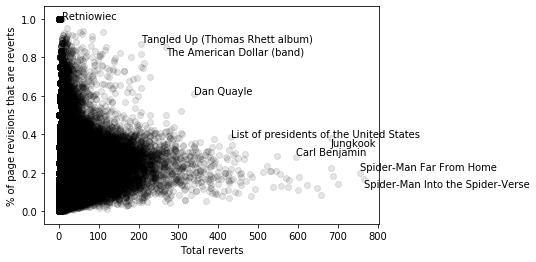

In [95]:
plt.scatter(page_df.revert_count, page_df.pct_reverts, color='black', alpha=0.1)

plt.xlabel("Total reverts")
plt.ylabel("% of page revisions that are reverts")

for i, tup in enumerate(page_df[(page_df.revert_count > 200)&(page_df.pct_reverts > 0.82)].itertuples()):
    plt.text(tup.revert_count, tup.pct_reverts, f"{page_title_dict[tup.page_id]}", va='top' if i == 0 else 'bottom')
for tup in page_df[(page_df.revert_count > 320)&(page_df.pct_reverts > 0.6)].itertuples():
    plt.text(tup.revert_count, tup.pct_reverts, f"{page_title_dict[tup.page_id]}")
for tup in page_df[(page_df.revert_count > 400)&(page_df.pct_reverts > 0.385)].itertuples():
    plt.text(tup.revert_count, tup.pct_reverts, f"{page_title_dict[tup.page_id]}")
for i, tup in enumerate(page_df[(page_df.revert_count > 590)&(page_df.pct_reverts > 0.25)].itertuples()):
    plt.text(tup.revert_count, tup.pct_reverts, f"{page_title_dict[tup.page_id]}", va='top' if i == 0 else 'bottom')
for i, tup in enumerate(page_df[(page_df.revert_count > 750)&(page_df.pct_reverts > 0.1)].itertuples()):
    plt.text(tup.revert_count, tup.pct_reverts, f"{page_title_dict[tup.page_id]}", va='top' if i == 0 else 'bottom')
for tup in page_df[(page_df.revert_count > 6)&(page_df.pct_reverts >= 1)].itertuples():
    plt.text(tup.revert_count, tup.pct_reverts, f"{page_title_dict[tup.page_id]}")

    
plt.show()

Retniowiec: "Revert an apparently malfunctioning bot".  User and bot do a small edit war, so all edit up identified as reverts.  https://en.wikipedia.org/w/index.php?title=Retniowiec&action=history

Tangled Up: "Protected [page]: Persistent sock puppetry" A user with multiple sock puppets was vandalizing this page in early Sept 2019. https://en.wikipedia.org/w/index.php?title=Tangled_Up_(Thomas_Rhett_album)&action=history

The American Dollar: Some kind of weird edit-war. Several sockpuppets, likely controlled by the band themselves. "Wikipedia is a lame dictatorship of brown nosing nerds and losers." https://en.wikipedia.org/wiki/Talk:The_American_Dollar_(band)

Dan Quayle: Disagreement about how much discussion of Quayle's gaffes is appropriate. Lots of partisans trying to remove extensive discussion of gaffes. https://en.wikipedia.org/wiki/Talk:Dan_Quayle

List of presidents of the United States: I'm not really sure why this is such an outlier.  It is related to politics?  See figure below, no obvious temporal spikes except in Feb 2018. 

Jungkook: BTS stans.  "There have been attempts to recruit editors of specific viewpoints to this article". https://en.wikipedia.org/wiki/Talk:Jungkook

Carl Benjamin:  (FYI, this is Sargon of Akkad).  So this is GamerGate and gender controversy.  It seems msot of the controversy is related to whether or not it is fair to say Sargon is anti-feminist and associated with the alt-right in the lede.  https://en.wikipedia.org/w/index.php?title=Carl_Benjamin&offset=20191111155136&action=history

Spider-Man Far From Home: Persistent vandalism, lots of original research (seemingly related to easter eggs in the film). https://en.wikipedia.org/w/index.php?title=Spider-Man:_Far_From_Home&offset=20200101012016&action=history

Spider-man Into the Spider-Verse: This is one of the most-viewed Wikipedia articles.  Seemingly normal percentage of reverts.

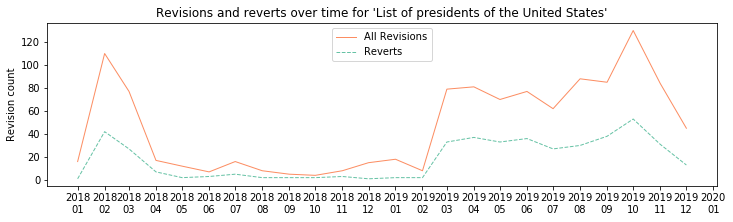

('List of presidents of the United States', 19908980.0)

In [110]:
target_page_id = page_df[(page_df.revert_count > 400)&(page_df.pct_reverts > 0.385)].iloc[0].page_id
target_page_title = page_title_dict[target_page_id]
# count only revisions on this page
sdf = df[df.page_id == target_page_id]

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

hist, bin_edges = np.histogram(sdf.rev_timestamp, bins=bins)
ln1 = ax.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='All Revisions', color=cmap(0.2))
hist, bin_edges = np.histogram(sdf[sdf.is_reverting == 1].rev_timestamp, bins=bins)
ln2 = ax.plot(bin_edges[:-1], hist, linestyle='--', linewidth=1, label='Reverts', color=cmap(0))
ax.set_xticks(bins)
ax.set_xticklabels([datetime.utcfromtimestamp(ts).strftime('%Y\n%m') for ts in bins])
ax.set_title(f"Revisions and reverts over time for '{target_page_title}'")
ax.set_ylabel("Revision count")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)

plt.show()

target_page_title, target_page_id

In [104]:
df

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting
0,12,818611292,1515101356,0,0,0
1,12,818613649,1515102279,0,0,0
2,12,818624114,1515106953,1,0,0
3,12,820024812,1515798752,0,1,0
4,12,820025687,1515799060,0,0,1
...,...,...,...,...,...,...
77287692,62715690,933353502,1577815795,0,0,0
77287693,62715690,933353698,1577815916,0,0,0
77287694,62715690,933354601,1577816437,0,0,0
77287695,62715690,933421734,1577848192,0,0,0


In [69]:
for i, t in enumerate(page_df[page_df.revision_count >= 100].sort_values(by='pct_reverts', ascending=False).itertuples()):
    print(f"{page_title_dict[t.page_id]:>50} {t.revert_count} / {t.revision_count} ({t.pct_reverts*100:.2f}%)")
    if i > 30:
        break

                                           Biduino 111 / 119 (93.28%)
                   Tangled Up (Thomas Rhett album) 206 / 237 (86.92%)
                                   Hazel-Ann Regis 117 / 137 (85.40%)
                        The American Dollar (band) 268 / 314 (85.35%)
                                  Progressive scan 115 / 137 (83.94%)
                                Battle of Shanggao 91 / 109 (83.49%)
                                 Totally Hits 2003 153 / 186 (82.26%)
                        Thor Ragnarok (soundtrack) 104 / 127 (81.89%)
Dragon Quest Heroes The World Tree's Woe and the Blight Below 207 / 253 (81.82%)
                      2005 Cleveland Browns season 108 / 132 (81.82%)
                            Battle of Pingxingguan 100 / 124 (80.65%)
                                      John Barrard 103 / 128 (80.47%)
                                Kotromanić dynasty 181 / 226 (80.09%)
                                   Market! Market! 84 / 105 (80.00%)
           

Biduino: A single new user made added and removed a single period over a single day in July 2018.  So, nearly all are reverts.

Thor Ragnarok (soundtrack): Seems like a lot of fighting about genre? Interestingly, it looks like the same troll/sockpuppet as on the Tangled Up page.

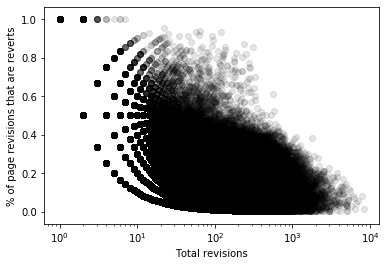

In [112]:
# Total revisions vs percentage reverts
plt.scatter(page_df.revision_count, page_df.pct_reverts, color='black', alpha=0.1)
plt.xscale('log')

plt.xlabel("Total revisions")
plt.ylabel("% of page revisions that are reverts")
    
plt.show()

### Protected page analysis

Brings in data for protected pages and does some computing to assess the impact of page protection on reverts.

In [240]:
repo_raw_data_dir = os.path.join(git_root_dir, "data", "raw")
protected_pages_filepath = os.path.join(repo_raw_data_dir, 'protected_pages', 'quarry-42681-edit-protected-pages.csv')
editprotected_df = pd.read_csv(protected_pages_filepath, header=0)
len(editprotected_df)

70286

In [249]:
# Merge in page protection data
page_df = page_df.merge(editprotected_df[['pr_level', 'page_id']], how='left', on='page_id')
page_df['is_edit_protected'] = ~pd.isna(res.pr_level)
page_df.head()

,page_id,revert_count,revision_count,pct_reverts,pr_level,is_edit_protected
0,47069739,765,4540,0.168502,NaN,False
1,52179698,755,3739,0.201926,NaN,False
2,44254295,701,4847,0.144626,autoconfirmed,True
3,12767523,688,3779,0.182059,autoconfirmed,True
4,57703645,682,1784,0.382287,autoconfirmed,True


In [253]:
f"{np.sum(page_df.is_edit_protected) / len(page_df)*100:.2f}% of pages are edit-protected as of March 02, 2020"

'0.81% of pages are edit-protected as of March 02, 2020'

In [254]:
Counter(page_df.pr_level).most_common()

[(nan, 1154369),
 ('autoconfirmed', 8557),
 ('extendedconfirmed', 859),
 ('sysop', 14)]

In [258]:
page_df[page_df.pr_level == 'sysop'].merge(page_title_df, on='page_id')

,page_id,revert_count,revision_count,pct_reverts,pr_level,is_edit_protected,page_title
0,57063312,225,1674,0.134409,sysop,True,Douma chemical attack
1,13425260,191,1142,0.167250,sysop,True,List of programs broadcast by Nicktoons
2,7651709,88,210,0.419048,sysop,True,Siddha medicine
3,28721,80,808,0.099010,sysop,True,Amsterdam Airport Schiphol
4,1351345,60,341,0.175953,sysop,True,Momo (food)
5,24470851,29,113,0.256637,sysop,True,List of Republic Records artists
6,2314027,26,169,0.153846,sysop,True,Religion in Albania
7,16766071,17,166,0.102410,sysop,True,Richard Grenell
8,4558855,12,56,0.214286,sysop,True,Selman Akbulut
9,15580374,11,34,0.323529,sysop,True,Main Page


Sysop-level protections seem to be temporary.

 - Religion in Albania was locked for 7 days following a small edit war. https://en.wikipedia.org/w/index.php?title=Religion_in_Albania&type=revision&diff=942624806&oldid=942624759
 - Amsterdam Airport Schiphol: 7 days for edit war. https://en.wikipedia.org/w/index.php?title=Amsterdam_Airport_Schiphol&type=revision&diff=942631083&oldid=942610530
 - Douma chemical attack. 30 day due to edit war. Investigating a particular section within the article during the locked period.
 - List of programs broadcast by Nicktoons: 6 month lock. Admin: "Protection will be resolved once an agreement is reached on the talk page regarding how to handle christmas episodes. Ping me when you have fixed that problem." https://en.wikipedia.org/w/index.php?title=List_of_programs_broadcast_by_Nicktoons&oldid=940130429
 - Siddha medicine. 30 days.  "Edit warring / content dispute: a long breather while the next steps are considered." https://en.wikipedia.org/w/index.php?title=Siddha_medicine&oldid=940614411
 - Momo (food): 7 days. Edit war.
 - List of Republic Records artists: 7 days. Edit war.
 - Richard Grenell: 7 days. Content dispute.
 - Selman Akbulut: 15 days. "There appears to be an ongoing dispute between subject and their employer, with editors apparently changing content to benefit one side or another. Attempting to bring some impartiality/neutrality to this page."  Discussion centers on allegations that resulted in loss of tenure.
 - Main Page: It's the main page of Wikipedia!
 - Indigenous Aryans: Indefinite.  "per WP:PREFER - when consensus established can be lowered back to autoconfirmed" https://en.wikipedia.org/w/index.php?title=Indigenous_Aryans&oldid=942044035
 - Elohim (musician): 30 days. Edit war related to revealing the real name of this artist.  
 - Theeyar: Redirect, protected due to ["persistent sock puppetry: see also protection at Thiyya"](https://en.wikipedia.org/w/index.php?title=Theeyar&oldid=936088985). Now redirects to [Ezhava](https://en.wikipedia.org/wiki/Ezhava).
 - Smell the Glove: Redirect, protected after a request for deletione finished processing.  ["Protected "Smell the Glove": Per Wikipedia:Articles for deletion/Smell the Glove (3rd nomination) and past restorations of the article following earlier AFDs."](https://en.wikipedia.org/w/index.php?title=Smell_the_Glove&oldid=934819569)

In [264]:
page_df[page_df.pr_level == 'extendedconfirmed'].sample(n=5, random_state=5).merge(page_title_df, on='page_id')

,page_id,revert_count,revision_count,pct_reverts,pr_level,is_edit_protected,page_title
0,7451511,187,731,0.255814,extendedconfirmed,True,Jaggi Vasudev
1,5179641,186,755,0.246358,extendedconfirmed,True,InfoWars
2,16454727,1,10,0.100000,extendedconfirmed,True,Bhumihar
3,1645949,1,95,0.010526,extendedconfirmed,True,Arab Jews
4,12548719,1,23,0.043478,extendedconfirmed,True,Deir Dibwan


 - Jaggi Vasudev: "Changed protection level for "Jaggi Vasudev": Arbitration enforcement: Up, extend protection: suspected paid editing or editing by Isha Foundation members ([Edit=Require extended confirmed access] (indefinite)"

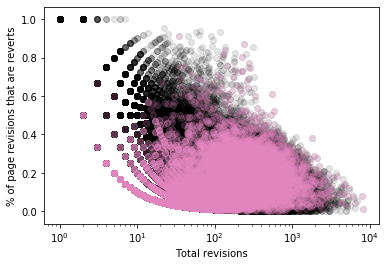

In [277]:
# Total revisions vs percentage reverts
plt.scatter(page_df.revision_count, page_df.pct_reverts, color='black', alpha=0.1)
subset = page_df[page_df.is_edit_protected]
plt.scatter(subset.revision_count, subset.pct_reverts, color=cmap(0.4), alpha=0.2)
plt.xscale('log')

plt.xlabel("Total revisions")
plt.ylabel("% of page revisions that are reverts")
    
plt.show()

In [272]:
page_df['is_edit_protected_int'] = page_df.is_edit_protected.astype(int)
page_df['pct_reverts_pts'] = page_df.pct_reverts * 100

In [273]:
formula = """
is_edit_protected_int ~ 
    revision_count 
    + pct_reverts_pts
    + 1
"""
# + num_sites OR is_multisite_author
# + health_condition
model = smf.logit(formula=formula, 
                  data=page_df)
res = model.fit(maxiter=100)
res.summary()

Optimization terminated successfully.
         Current function value: 0.043629
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     is_edit_protected_int   No. Observations:              1163799
Model:                             Logit   Df Residuals:                  1163796
Method:                              MLE   Df Model:                            2
Date:                   Tue, 03 Mar 2020   Pseudo R-squ.:                 0.07349
Time:                           09:01:11   Log-Likelihood:                -50775.
converged:                          True   LL-Null:                       -54802.
Covariance Type:               nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.2298      0.017   -305.162      0.000      -5.263      -5.196
revision_count      0.0035   3.69e-05     93.653      0.000       0.003       0.004
pct_reverts_pts     0.0085      0.001     11.338      0.000       0.007       0.010
===================================================================================
"""

In [274]:
np.exp(res.params)-1

Intercept         -0.994645
revision_count     0.003464
pct_reverts_pts    0.008520
dtype: float64

Each additional percentage point of revisions that are reverts is associated with a 0.8% increase in the odds of a page being protected.

In [275]:
formula = """
revert_count ~ 
    revision_count 
    + is_edit_protected_int
    + 1
"""
# + num_sites OR is_multisite_author
# + health_condition
model = smf.ols(formula=formula, 
                  data=page_df)
res = model.fit(maxiter=100)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           revert_count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                 7.914e+05
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:02:17   Log-Likelihood:            -4.2622e+06
No. Observations:             1163799   AIC:                         8.524e+06
Df Residuals:                 1163796   BIC:                         8.524e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3873      0.010     40.658      0.000       0.369       0.406
revision_count            0.1069   8.87e-05   1205.066      0.000       0.107       0.107
is_edit_protected_int    12.8395      0.099    129.424      0.000      12.645      13.034
==============================================================================
Omnibus:                   849243.596   Durbin-Watson:                   1.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2715540425.475
Skew:                           1.906   Prob(JB):                         0.00
Kurtosis:                     239.613   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression above shows that, controlling for total number of revisions, a page being protected in March 2020 is associated with 12.8 additional revert revisions on average.

#### 2d histograms of articles with high % of reverts for their size

With explicit labels to make it easier to investigate some of the outliers from above.

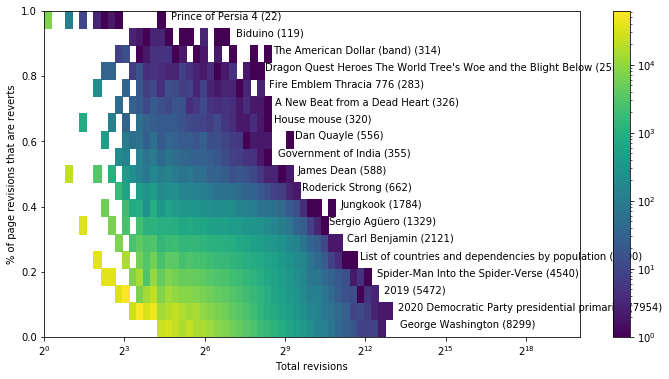

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x = page_df.revision_count
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
#plt.hist(x, bins=logbins, color='gray')
_,_,_,im = plt.hist2d(x, page_df.pct_reverts, bins=[logbins, np.linspace(0, 1.0, num=20)], norm=matplotlib.colors.LogNorm())
plt.colorbar(im)
plt.xscale('log', nonposx='clip', basex=base)
plt.xlim(1, 2**20)

plt.xlabel("Total revisions")
plt.ylabel("% of page revisions that are reverts")


for i, pct_revert in enumerate(np.linspace(0, 1.0, num=20)):
    if i >= 0 and i != 19:
        subset = page_df[(page_df.pct_reverts >= pct_revert)&(page_df.pct_reverts <= pct_revert + 1/20)]
        tup = subset.sort_values('revision_count', ascending=False).iloc[0]
        idx = np.searchsorted(np.linspace(0, 1.0, num=20), tup.pct_reverts)
        #idx = (np.abs(np.linspace(0, 1.0, num=20) - tup.pct_reverts)).argmin()
        text_y = np.linspace(0, 1.0, num=20)[idx]
        plt.text(tup.revision_count * 1.2, text_y, f"{page_title_dict[tup.page_id]} ({int(tup.revision_count)})", va='top')


plt.show()

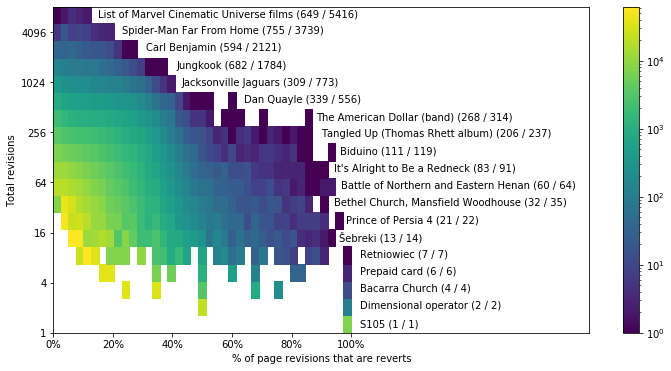

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

y = page_df.revision_count
num_bins=20
base = 2
logbins = np.logspace(np.log2(min(y)), np.log2(max(y)), num=num_bins, base=base, endpoint=True)
#plt.hist(x, bins=logbins, color='gray')
_,_,_,im = plt.hist2d(page_df.pct_reverts, y, bins=[np.linspace(0, 1.0, num=40), logbins], norm=matplotlib.colors.LogNorm())
plt.colorbar(im)
plt.yscale('log', nonposy='clip', basey=base)
plt.xlim(0, 1.8)

plt.xlabel("% of page revisions that are reverts")
plt.ylabel("Total revisions")
ax.set_yticklabels([int(ytick) for ytick in ax.get_yticks()])
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels([f"{int(xtick*100)}%" for xtick in [0.0, 0.2, 0.4, 0.6, 0.8, 1]])

for i, right_edge in enumerate(logbins[1:]):
    left_edge = logbins[i]
    subset = page_df[(page_df.revision_count >= left_edge)&(page_df.revision_count <= right_edge)]
    tup = subset.sort_values('pct_reverts', ascending=False).iloc[0]
    idx = np.searchsorted(logbins, tup.revision_count)
    text_y = logbins[idx] * 0.95
    if i == 0:  # because of how log-scaling works around 1, need to manually adjust the bottom-most label
        text_y += 0.5
    plt.text(tup.pct_reverts + 0.03, text_y, f"{page_title_dict[tup.page_id]} ({int(tup.revert_count)} / {int(tup.revision_count)})", va='top')


plt.show()

### Requesting restriction info about pages

Brief aside exploring using the API to identify if a page is restricted or not.

In [182]:
import requests

In [188]:
params = {
    'action': 'query',
    'format': 'json',
    'pageids': str(int(target_page_id)),
    'prop': 'info',
    'inprop': 'url|protection'
}
resp = requests.get("https://en.wikipedia.org/w/api.php", params=params)
print(resp)
print(resp.json())

<Response [200]>
{'batchcomplete': '', 'query': {'pages': {'19908980': {'pageid': 19908980, 'ns': 0, 'title': 'List of presidents of the United States', 'contentmodel': 'wikitext', 'pagelanguage': 'en', 'pagelanguagehtmlcode': 'en', 'pagelanguagedir': 'ltr', 'touched': '2020-02-28T12:49:12Z', 'lastrevid': 943037223, 'length': 41496, 'protection': [], 'restrictiontypes': ['edit', 'move'], 'fullurl': 'https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States', 'editurl': 'https://en.wikipedia.org/w/index.php?title=List_of_presidents_of_the_United_States&action=edit', 'canonicalurl': 'https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States'}}}}


In [189]:
for key in page_title_dict:
    value = page_title_dict[key]
    if value.startswith("Bethel Church,"):
        print(key, value)

43825897 Bethel Church, Mansfield Woodhouse
47944032 Bethel Church, Aleppo


In [190]:
params = {
    'action': 'query',
    'format': 'json',
    'pageids': str(43825897),
    'prop': 'info',
    'inprop': 'url|protection'
}
resp = requests.get("https://en.wikipedia.org/w/api.php", params=params)
print(resp)
print(resp.json())

<Response [200]>
{'batchcomplete': '', 'query': {'pages': {'43825897': {'pageid': 43825897, 'ns': 0, 'title': 'Bethel Church, Mansfield Woodhouse', 'contentmodel': 'wikitext', 'pagelanguage': 'en', 'pagelanguagehtmlcode': 'en', 'pagelanguagedir': 'ltr', 'touched': '2020-02-09T10:07:54Z', 'lastrevid': 870460930, 'length': 20559, 'protection': [{'type': 'edit', 'level': 'autoconfirmed', 'expiry': 'infinity'}, {'type': 'move', 'level': 'autoconfirmed', 'expiry': 'infinity'}], 'restrictiontypes': ['edit', 'move'], 'fullurl': 'https://en.wikipedia.org/wiki/Bethel_Church,_Mansfield_Woodhouse', 'editurl': 'https://en.wikipedia.org/w/index.php?title=Bethel_Church,_Mansfield_Woodhouse&action=edit', 'canonicalurl': 'https://en.wikipedia.org/wiki/Bethel_Church,_Mansfield_Woodhouse'}}}}


### BTS-specific analysis

As Jungkook was a clear outlier in the above, I decided to investigate other BTS members' pages.

https://twitter.com/zwlevonian/status/1234533913000849408

In [193]:
# BTSARMY
# We identify the page-ids for 8 BTS-related pages
bts_page_titles = [
    'J-Hope',
    'Jimin (singer, born 1995)',
    'Jungkook',
    'Kim Seok-jin',
    'RM (rapper)',
    'Suga (rapper)',
    'V (singer)',
    'BTS (band)'
]
bts_page_ids = [-1 for title in bts_page_titles]
for key in page_title_dict:
    if key not in page_ids_set:
        continue
    value = page_title_dict[key]
    for i, bts_page in enumerate(bts_page_titles):
        if value.startswith(bts_page):
            bts_page_ids[i] = key
            #print(key, value)
assert np.all([page_id != -1 for page_id in bts_page_ids])

In [196]:
bts_page_ids = set(bts_page_ids)

Mean percentage of revert revisions: 10.67%
Jungkook 0.38228699551569506 False
Kim Seok-jin 0.2865853658536585 False
J-Hope 0.2644135188866799 False
Jimin (singer, born 1995) 0.21921641791044777 False
Suga (rapper) 0.25128865979381443 False
BTS (band) 0.09994655264564405 True
RM (rapper) 0.1592775041050903 False
V (singer) 0.11818181818181818 False


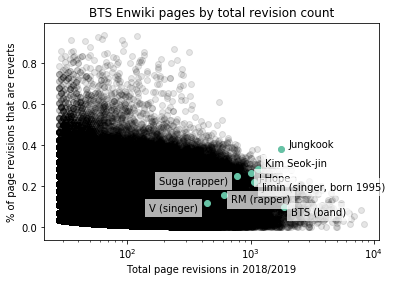

In [233]:
# Plot the BTS members as total revisions vs pct reverts
subset = page_df[page_df.revision_count >= 28]
# 28 is the 90th percentile revision count, so we visualize here only the top-10% of Enwiki pages
plt.scatter(subset.revision_count, subset.pct_reverts, color='black', alpha=0.1)
mean_revert = np.mean(subset.pct_reverts)
print(f"Mean percentage of revert revisions: {mean_revert*100:.2f}%")
bts_subset = subset[subset.page_id.isin(bts_page_ids)]
plt.scatter(bts_subset.revision_count, bts_subset.pct_reverts, color=cmap(0), alpha=1)

for i, tup in enumerate(bts_subset.itertuples()):
    x = tup.revision_count * 1.15 if i < 7 and i != 4 else tup.revision_count * 0.85
    plt.text(x, tup.pct_reverts, f"{page_title_dict[tup.page_id]}", 
             va='bottom' if i <= 1 else 'top', color='black',
             ha='left' if i < 7 and i != 4 else 'right',
            bbox=dict(facecolor='white', alpha=0.7, linewidth=0))
    # Only the band page is below the mean number of reverts
    print(page_title_dict[tup.page_id], tup.pct_reverts, tup.pct_reverts < mean_revert)


plt.xscale('log')

plt.title("BTS Enwiki pages by total revision count")
plt.xlabel("Total page revisions in 2018/2019")
plt.ylabel("% of page revisions that are reverts")

plt.savefig(os.path.join(figures_dir, "bts_rev_count.png"), dpi=150)
plt.show()

### Time-to-revert and user analysis

In [279]:
time_to_most_recent_reverted_list = []
is_multirevert_list = []
for page, page_reverts in tqdm(groupby(reverts, lambda revert: revert['reverting']['page']['id']), total=len(page_df)):
    page_reverts = list(page_reverts)
    for revert in page_reverts:
        reverted_at_timestamp = int(datetime.strptime(revert['reverting']['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        reverted_to_timestamp = int(datetime.strptime(revert['reverted_to']['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        reverteds = sorted(revert['reverteds'], key=lambda r: (r.get('timestamp'), r.get('id')))
        is_multirevert = len(reverteds) > 1
        revert_timestamp = int(datetime.strptime(reverteds[-1]['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        time_to_most_recent_reverted = reverted_at_timestamp - revert_timestamp
        time_to_most_recent_reverted_list.append(time_to_most_recent_reverted)
        is_multirevert_list.append(is_multirevert)

100%|██████████| 1163799/1163799 [05:44<00:00, 3382.29it/s]


In [281]:
# shows degenerate timings; hopefully this rarely happens
np.sum(np.array(time_to_most_recent_reverted_list) <= 0), \
np.sum(np.array(time_to_most_recent_reverted_list) <= 0) / len(time_to_most_recent_reverted_list)

(484, 8.076517325631495e-05)

In [282]:
# percent of reverts that occur after more than a day
np.sum(np.array(time_to_most_recent_reverted_list) >= 60 * 60 * 24) / len(time_to_most_recent_reverted_list)

0.11357652550227093

In [285]:
# percent of reverts that occur after more than a minute
np.sum(np.array(time_to_most_recent_reverted_list) >= 60) / len(time_to_most_recent_reverted_list)

0.7186421705673687

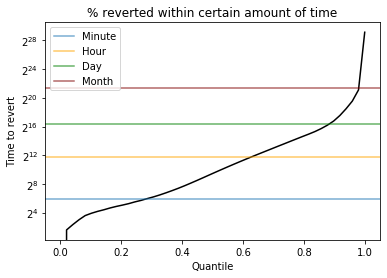

In [283]:
x = np.array(time_to_most_recent_reverted_list)
qs = np.linspace(0, 1)
ys = [np.quantile(x, q) for q in qs]
plt.plot(qs, ys, color='black')
plt.yscale('log', nonposy='clip', basey=2)

ax = plt.gca()
# add semantically interpretable time moments
ax.axhline(1 * 60, alpha=0.6, label='Minute')
ax.axhline(1 * 60 * 60, alpha=0.6, label='Hour', color='orange')
ax.axhline(1 * 60 * 60 * 24, alpha=0.6, label='Day', color='green')
ax.axhline(1 * 60 * 60 * 24 * 30, alpha=0.6, label='Month', color='maroon')

plt.legend()

plt.xlabel("Quantile")
plt.ylabel("Time to revert")
plt.title("% reverted within certain amount of time")

plt.show()

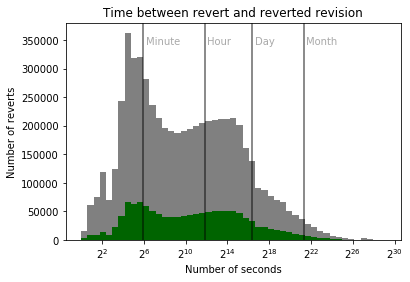

In [284]:
x = np.clip(np.array(time_to_most_recent_reverted_list), 1, None)
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='gray')
plt.hist(x[np.array(is_multirevert_list)], bins=logbins, color='darkgreen', label='Most recent of multi-reverted')
plt.xscale('log', nonposx='clip', basex=base)

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24 * 30, color='black', alpha=0.6)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.90))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1 * 60 * 1.2, text_y, 'Minute', color='darkgray')
ax.text(1 * 60 * 60 * 1.2, text_y, 'Hour', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 1.2, text_y, 'Day', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 30 * 1.2, text_y, 'Month', color='darkgray')

plt.title("Time between revert and reverted revision")
plt.xlabel("Number of seconds")
plt.ylabel("Number of reverts")

#plt.legend()

plt.show()

### Self-reverts and user analysis

In [286]:
is_self_revert_list = []
is_multiuser_revert_list = []
unique_reverted_user_counts = []
no_reverting_user_count = 0
for page, page_reverts in tqdm(groupby(reverts, lambda revert: revert['reverting']['page']['id']), total=len(page_df)):
    page_reverts = list(page_reverts)
    for revert in page_reverts:
        if 'user' not in revert['reverting']:
            no_reverting_user_count += 1
            continue
        reverting_user = revert['reverting']['user']['text']
        reverted_users = set([revert['user']['text'] for revert in revert['reverteds'] if 'user' in revert])
        
        is_self_revert = reverting_user in reverted_users
        is_self_revert_list.append(is_self_revert)
        is_multiuser_revert = len(reverted_users) > 1
        is_multiuser_revert_list.append(is_multiuser_revert)
        unique_reverted_user_counts.append(len(reverted_users))
            
is_self_revert_list = np.array(is_self_revert_list)
is_multiuser_revert_list = np.array(is_multiuser_revert_list)
unique_reverted_user_counts = np.array(unique_reverted_user_counts)
no_reverting_user_count

100%|██████████| 1163799/1163799 [00:44<00:00, 26308.16it/s]


169

In [287]:
# 11% of reverts revert the users own work
np.sum(is_self_revert_list), np.sum(is_self_revert_list) / len(is_self_revert_list)

(661185, 0.11033517991533769)

In [288]:
# 6.8% of reverts have multiple reverted users
np.sum(is_multiuser_revert_list) / len(is_multiuser_revert_list)

0.06784899757413959

In [289]:
# 37.2% of multi-user reverts involve the self
np.sum(is_self_revert_list&is_multiuser_revert_list) / np.sum(is_multiuser_revert_list)

0.3715745254386526

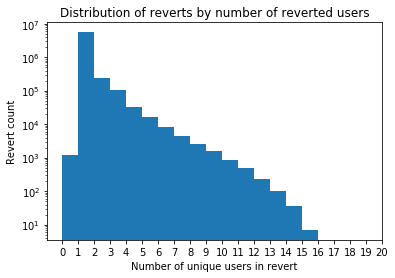

In [290]:
plt.hist(unique_reverted_user_counts, bins=range(0, 20), log=True)
plt.xticks(range(0, 21))
plt.title("Distribution of reverts by number of reverted users")
plt.xlabel("Number of unique users in revert")
plt.ylabel("Revert count")
plt.show()

### Compute and save reduced reverts data

Reduced version contains only page_id, rev_id, user identifier, and timestamp of the revisions.

In [303]:
revert_info_tups = []
for page, page_reverts in tqdm(groupby(reverts, lambda revert: revert['reverting']['page']['id']), total=len(page_df)):
    page_reverts = list(page_reverts)
    for revert in page_reverts:
        reverting_rev_id = revert['reverting']['id']
        reverted_to_rev_id = revert['reverted_to']['id']
        
        reverting_timestamp = int(datetime.strptime(revert['reverting']['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        reverted_to_timestamp = int(datetime.strptime(revert['reverted_to']['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        reverting_user = revert['reverting']['user']['text'] if 'user' in revert['reverting'] else None
        reverted_to_user = revert['reverted_to']['user']['text'] if 'user' in revert['reverted_to'] else None
        
        reverting_user_id = revert['reverting']['user']['id'] if 'user' in revert['reverting'] and 'id' in revert['reverting']['user'] else None
        reverted_to_user_id = revert['reverted_to']['user']['id'] if 'user' in revert['reverted_to'] and 'id' in revert['reverted_to']['user'] else None
        
        reverteds = sorted(revert['reverteds'], key=lambda r: (r.get('timestamp'), r.get('id')))
        reverteds_count = len(reverteds)
        reverteds_rev_ids = [rev['id'] for rev in reverteds]
        reverteds_timestamps = [
            int(datetime.strptime(rev['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
            for rev in reverteds
        ]
        reverteds_users = [
            rev['user']['text'] if 'user' in rev else None
            for rev in reverteds
        ]
        reverteds_user_ids = [
            rev['user']['id'] if 'user' in rev and 'id' in rev['user'] else None
            for rev in reverteds
        ]
        
        tup = (
            page, reverteds_count,
            reverting_rev_id, reverting_timestamp, reverting_user, reverting_user_id, 
            reverted_to_rev_id, reverted_to_timestamp, reverted_to_user, reverted_to_user_id, 
            reverteds_rev_ids, reverteds_timestamps, reverteds_users, reverteds_user_ids
        )
        revert_info_tups.append(tup)

100%|██████████| 1163799/1163799 [08:31<00:00, 2275.32it/s] 


In [304]:
column_names = [
            'page_id', 'reverted_count',
            'reverting_rev_id', 'reverting_timestamp', 'reverting_user_text', 'reverting_user_id',
            'reverted_to_rev_id', 'reverted_to_timestamp', 'reverted_to_user_text', 'reverted_to_user_id',
            'reverted_rev_ids', 'reverted_timestamps', 'reverted_user_texts', 'reverted_user_ids'
]
revert_df = pd.DataFrame(revert_info_tups, columns=column_names)
len(revert_df)

5992682

In [316]:
# identify anonymous users
revert_df['reverting_user_is_anonymous'] = pd.isna(revert_df.reverting_user_id)
revert_df['reverted_to_user_is_anonymous'] = pd.isna(revert_df.reverted_to_user_id)
revert_df['reverted_users_is_anonymous'] = revert_df.reverted_user_ids.map(lambda id_list: pd.isna(id_list))

In [317]:
revert_df.head()

,page_id,reverted_count,reverting_rev_id,reverting_timestamp,reverting_user_text,reverting_user_id,reverted_to_rev_id,reverted_to_timestamp,reverted_to_user_text,reverted_to_user_id,reverted_rev_ids,reverted_timestamps,reverted_user_texts,reverted_user_ids,reverting_user_is_anonymous,reverted_to_user_is_anonymous,reverted_users_is_anonymous
0,18754764,1,902766646,1561105801,Malcolmxl5,4076676.0,874884880,1545481829,Hmains,508734.0,[900328973],[1559706521],[2601:199:417F:8EED:A0B0:A6B5:3457:A9B4],[None],False,False,[True]
1,18754831,2,818980415,1515284429,BrownHairedGirl,754619.0,743241620,1475970276,Emir of Wikipedia,28856560.0,"[757539852, 775847398]","[1483188655, 1492452285]","[Ser Amantio di Nicolao, Emir of Wikipedia]","[753665, 28856560]",False,False,"[False, False]"
2,18754831,1,932235094,1577204938,UA3,25923702.0,918313790,1569654385,Monkbot,20483999.0,[932233860],[1577204033],[Qowa],[37692801],False,False,[False]
3,18754864,1,853153047,1533256539,Beetstra,855858.0,831996274,1521801439,KolbertBot,31691822.0,[846149041],[1529188413],[Lepidoptera~plwiki],[24892933],False,False,[False]
4,18754916,1,882182106,1549557841,Number 57,327289.0,847748130,1530126769,CitationCleanerBot,15270283.0,[882125775],[1549520001],[Huldra],[410653],False,False,[False]


In [320]:
revert_df_filepath = os.path.join(working_dir, 'revert_df.pkl')
revert_df.to_pickle(revert_df_filepath)
print("Finished.")

Finished.


In [ ]:
# Read the revert info
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
revert_df_filepath = os.path.join(stub_history_reverts_dir, 'revert_df.pkl')
revert_df = pd.read_pickle(revert_df_filepath)
len(revert_df)

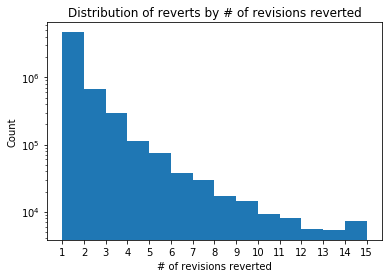

0.7846620261178551

In [327]:
# distribution of multi-reverts
plt.hist(revert_df.reverted_count, bins=range(1,16), log=True)
plt.xticks(range(1,16))
plt.title("Distribution of reverts by # of revisions reverted")
plt.ylabel("Count")
plt.xlabel("# of revisions reverted")
plt.show()
# 78.5% of reverts target only a single revision
np.sum(revert_df.reverted_count == 1) / len(revert_df)